In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
from core.models import MNISTDense
from core.initializers import He, Xavier
from core.optimizers import GradDesc, Momentum, Adagrad, RMSProp, Adam
from core.losses import Crossentropy
from core.activations import ReLu, Softmax
from core.metrics import Precision, Recall, Roc_Auc

## Считывание данных из бинарных файлов

In [3]:
project_path =  Path.cwd().parent
data_path = project_path / "data"
preproc_path = data_path / "preprocessed"

source_train_im_path = preproc_path / "train-images-idx3-ubyte.bin"
source_train_l_path = preproc_path / "train-labels-idx1-ubyte.bin"
source_test_im_path = preproc_path / "t10k-images-idx3-ubyte.bin"
source_test_l_path = preproc_path / "t10k-labels-idx1-ubyte.bin"


### Обучающая выборка

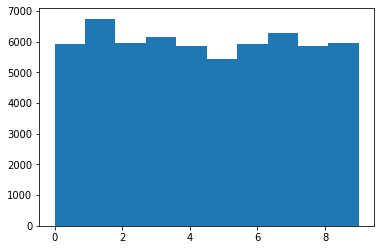

In [4]:
# Метки обуающей выборки
train_labels = np.fromfile(source_train_l_path, dtype=np.uint8, offset=8)
plt.hist(train_labels);

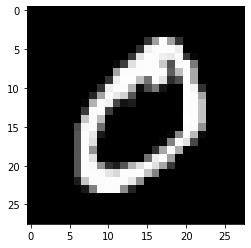

In [5]:
# Изображения обучающей выборки
train_size, rows, columns = 60000, 28, 28
train_images = np.fromfile(source_train_im_path, dtype=np.uint8, offset=16).reshape((train_size, rows, columns))
plt.imshow(train_images[1,:,:], cmap='gray')

### Тестовая выборка

In [6]:
# Метки тестовой выборки
# test_labels = np.fromfile(source_test_l_path, dtype=np.uint8, offset=8)
# plt.hist(test_labels);

In [7]:
# Изображения тестовой выборки
# test_size, rows, columns = 10000, 28, 28
# test_images = np.fromfile(source_test_im_path, dtype=np.uint8, offset=16).reshape((test_size, rows, columns))
# plt.imshow(test_images[1,:,:], cmap='gray')

## Создадим модель 

In [8]:
n_train = 30000
n_classes = 10
prepared_labels = train_labels[:n_train]
prepared_images = train_images[:n_train].reshape(n_train, -1)
prepared_images = (prepared_images > 0).astype(np.uint8)

### GradDesc

In [11]:
model_grad = MNISTDense(
    input_size=28*28,
    layers_sizes=[64, 32, 10],
    initializers_classes=[He, He, Xavier],
    activations_classes=[ReLu, ReLu, Softmax],
    optimizer=GradDesc(0.01),
    loss=Crossentropy,
    need_batch_normaliser=True
)
metrics = [Precision(), Recall()]
history_grad = model_grad.fit(10, 64, prepared_images, prepared_labels, metrics=metrics)

By epoch progress


Iter 1


375it [00:06, 55.33it/s]


Mean loss: 6
Validation scores: Precision 0.68 | Recall 0.62


Iter 2


375it [00:08, 44.10it/s]


Mean loss: 7
Validation scores: Precision 0.69 | Recall 0.62


Iter 3


375it [00:08, 45.44it/s]


Mean loss: 7
Validation scores: Precision 0.69 | Recall 0.64


Iter 4


375it [00:09, 41.18it/s]


Mean loss: 7
Validation scores: Precision 0.7 | Recall 0.65


Iter 5


375it [00:09, 40.73it/s]


Mean loss: 6
Validation scores: Precision 0.7 | Recall 0.66


Iter 6


158it [00:03, 67.12it/s]

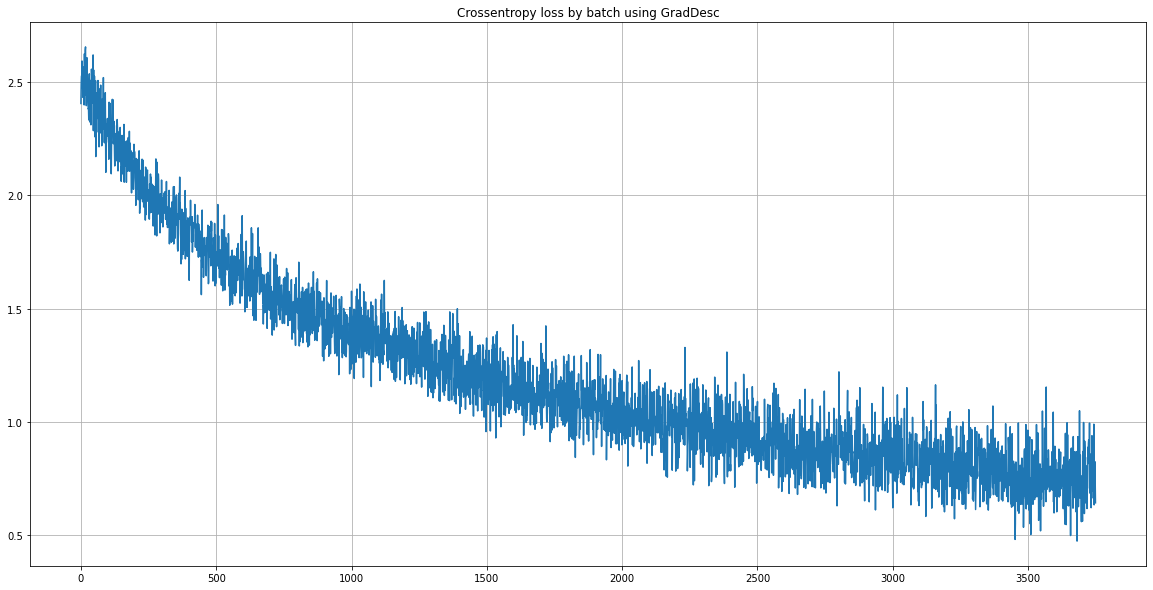

In [10]:
plt.figure(figsize=(20,10))
plt.title("Crossentropy loss by batch using GradDesc")
plt.grid()
plt.plot(history_grad.flatten())

### Momentum

In [11]:
model_momentum = MNISTDense(
    input_size=28*28,
    layers_sizes=[64, 32, 10],
    initializers_classes=[He, He, Xavier],
    activations_classes=[ReLu, ReLu, Softmax],
    optimizer=Momentum(learning_rate=0.0001, momentum=0.9),
    loss=Crossentropy,
    need_batch_normaliser=True
)
metrics = [Precision(), Recall()]
history_momentum = model_momentum.fit(5, 32, prepared_images, prepared_labels, metrics=metrics)

By epoch progress
Iter 1


938it [00:18, 49.66it/s]


Iter 2


938it [00:19, 46.97it/s]


Iter 3


938it [00:13, 69.11it/s] 


Iter 4


938it [00:20, 45.53it/s]


Iter 5


938it [00:19, 48.81it/s]


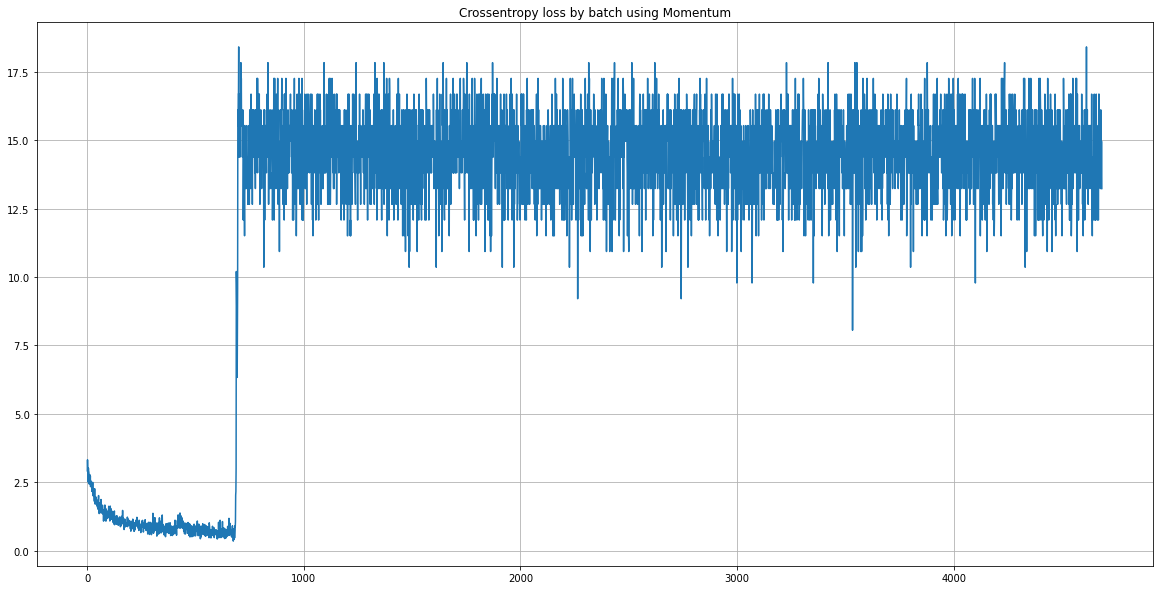

In [12]:
plt.figure(figsize=(20,10))
plt.title("Crossentropy loss by batch using Momentum")
plt.grid()
plt.plot(history_momentum.flatten())

### Adagrad

In [9]:
model_adagrad = MNISTDense(
    input_size=28*28,
    layers_sizes=[64, 32, 10],
    initializers_classes=[He, He, Xavier],
    activations_classes=[ReLu, ReLu, Softmax],
    optimizer=Adagrad(0.001),
    loss=Crossentropy,
    need_batch_normaliser=True
)
metrics = [Precision(), Recall()]
history_adagrad = model_adagrad.fit(5, 32, prepared_images, prepared_labels, metrics=metrics)

By epoch progress


Iter 1


750it [00:18, 40.30it/s]


Mean loss: 1
Validation scores: Precision 0.81 | Recall 0.8


Iter 2


750it [00:16, 45.61it/s]


Mean loss: 1
Validation scores: Precision 0.85 | Recall 0.84


Iter 3


750it [00:18, 40.25it/s]


Mean loss: 1
Validation scores: Precision 0.86 | Recall 0.85


Iter 4


750it [00:20, 36.93it/s]


Mean loss: 1
Validation scores: Precision 0.86 | Recall 0.86


Iter 5


750it [00:15, 48.83it/s]


Mean loss: 0
Validation scores: Precision 0.87 | Recall 0.86


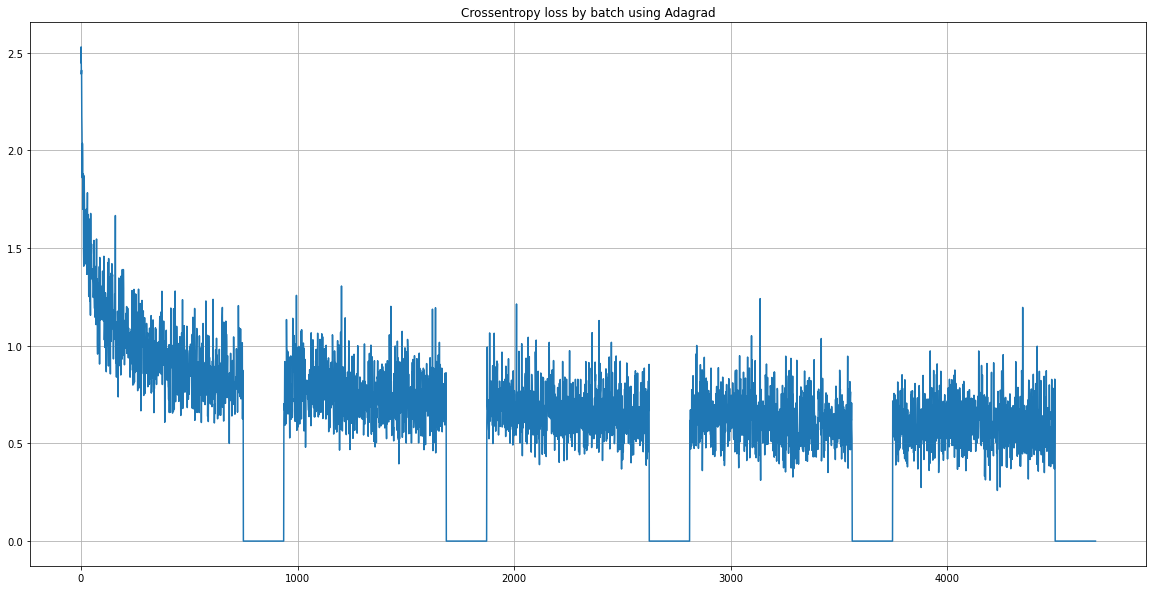

In [10]:
plt.figure(figsize=(20,10))
plt.title("Crossentropy loss by batch using Adagrad")
plt.grid()
plt.plot(history_adagrad.flatten())

### RMSProp

In [21]:
model_rmsprop = MNISTDense(
    input_size=28*28,
    layers_sizes=[64, 32, 10],
    initializers_classes=[He, He, Xavier],
    activations_classes=[ReLu, ReLu, Softmax],
    optimizer=RMSProp(0.0001, momentum=0.45),
    loss=Crossentropy,
    need_batch_normaliser=True
)
history_rmsprop = model_rmsprop.fit(5, 32, prepared_images, prepared_labels)

By epoch progress
Iter 1


938it [00:22, 41.16it/s]


Iter 2


938it [00:20, 45.11it/s]


Iter 3


26it [00:00, 60.46it/s]/home/stepan/MIPT/second_sem/DeepLearning/handmade_nn/notebooks/../core/optimizers.py:71: RuntimeWarning: overflow encountered in add
  self.accum += self.m * self.accum + (1 - self.m) * np.power(error_der_matrix, 2)
938it [00:24, 37.63it/s]


Iter 4


938it [00:21, 44.19it/s]


Iter 5


938it [00:23, 39.52it/s]


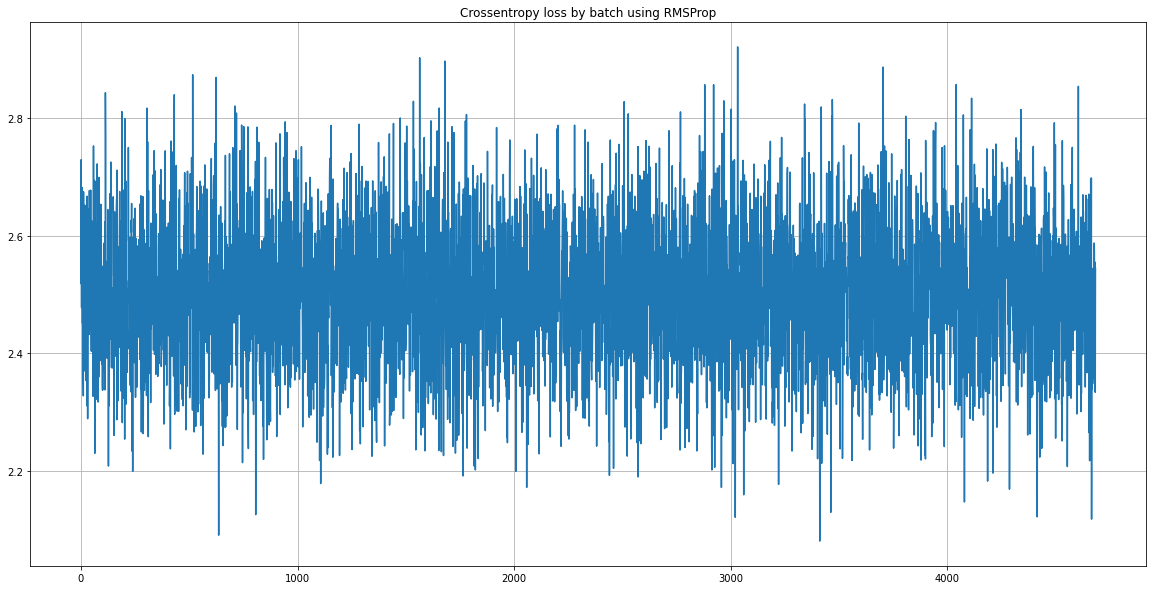

In [22]:
plt.figure(figsize=(20,10))
plt.title("Crossentropy loss by batch using RMSProp")
plt.grid()
plt.plot(history_rmsprop.flatten())

### Adam

In [19]:
model_adam = MNISTDense(
    input_size=28*28,
    layers_sizes=[64, 32, 10],
    initializers_classes=[He, He, Xavier],
    activations_classes=[ReLu, ReLu, Softmax],
    optimizer=Adam(0.001, momentum_1=0.9, momentum_2=0.999),
    loss=Crossentropy,
    need_batch_normaliser=True
)
history_adam = model_adam.fit(5, 32, prepared_images, prepared_labels)

By epoch progress
Iter 1


610it [00:11, 47.31it/s]/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
938it [00:18, 51.35it/s]


Iter 2


52it [00:00, 87.43it/s]/home/stepan/MIPT/second_sem/DeepLearning/handmade_nn/notebooks/../core/optimizers.py:99: RuntimeWarning: overflow encountered in multiply
  self.accum_2_ord_unbiased = self.accum_2_ord * self.im2
62it [00:00, 79.81it/s]/home/stepan/MIPT/second_sem/DeepLearning/handmade_nn/notebooks/../core/optimizers.py:96: RuntimeWarning: overflow encountered in add
  self.accum_2_ord += self.m2 * self.accum_2_ord + (1 - self.m2) * np.power(error_der_matrix, 2)
160it [00:02, 63.02it/s]/home/stepan/MIPT/second_sem/DeepLearning/handmade_nn/notebooks/../core/optimizers.py:98: RuntimeWarning: overflow encountered in multiply
  self.accum_1_ord_unbiased = self.accum_1_ord * self.im1
/home/stepan/MIPT/second_sem/DeepLearning/handmade_nn/notebooks/../core/optimizers.py:100: RuntimeWarning: invalid value encountered in true_divide
  return weights_matrix - self.accum_1_ord_unbiased * self.lr / np.sqrt(self.accum_2_ord_unbiased + self.eps)
476it [00:08, 56.30it/s]


KeyboardInterrupt: 

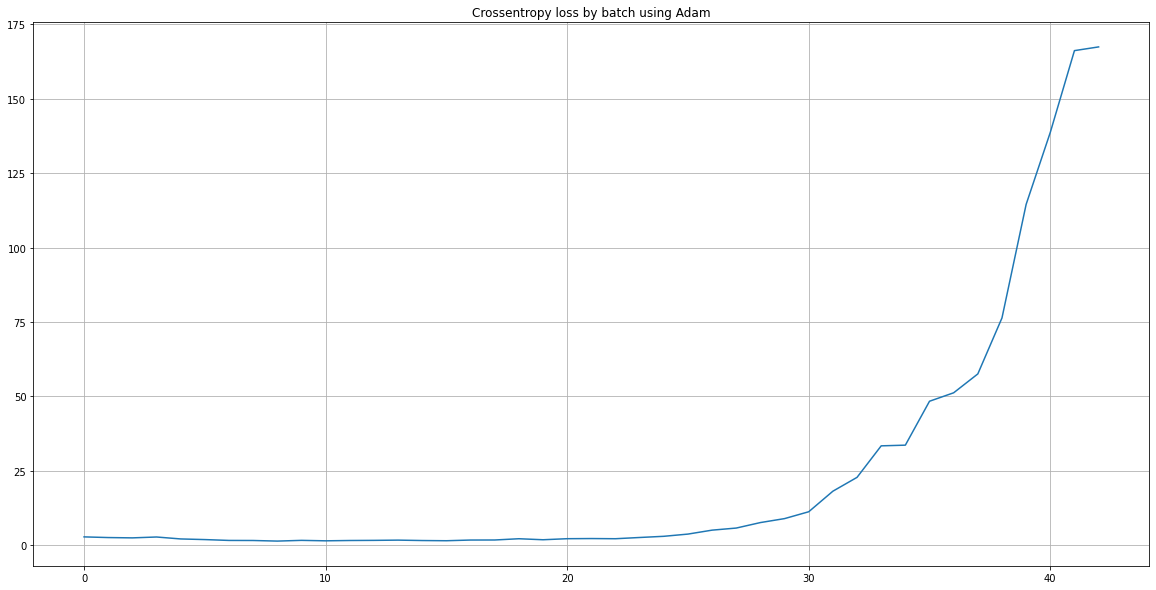

In [11]:
plt.figure(figsize=(20,10))
plt.title("Crossentropy loss by batch using Adam")
plt.grid()
plt.plot(history_adam.flatten())